## Long Short Term Memory Network (LSTM)



Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is specifically designed to handle sequential data, such as time series, speech, and text. LSTM networks are capable of learning long-term dependencies in sequential data, which makes them well suited for tasks such as language translation, speech recognition, and time series forecasting.

![image](https://www.aiplusinfo.com/wp-content/uploads/2022/06/Screen-Shot-2022-06-20-at-9.41.36-PM-1-1024x768.png?ezimgfmt=ngcb1/notWebP)

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
import re

from collections import defaultdict
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, optimizers, callbacks, backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load dataset from database

db = sqlite3.connect('C:/Users/HP/BInar/WAN PLATINUM/database.db', check_same_thread=False)
query_data = 'SELECT * FROM data'
data = pd.read_sql_query(query_data, db)
data.head(10)

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
5,makanan beragam harga makanan di food stall ak...,positive
6,pakai kartu kredit baca tidak untung malah rug...,negative
7,tempat unik bagus buat foto makanan enak pegaw...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [3]:
# Data distribution check

data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Oversampling and Feature-Label Classification

We will oversample the data with the neutral label to match the number of samples with the negative label (1138 to 3412).

In [4]:
# Label classification

# Filter data by label
df_positive = data[data['Label'] == 'positive']
df_negative = data[data['Label'] == 'negative']
df_neutral = data[data['Label'] == 'neutral']

# Oversample neutral label to match negative label
df_neutral_over = df_neutral.sample(df_negative.shape[0], replace=True)

# Merge balanced labels
data = pd.concat([df_positive, df_negative, df_neutral_over])

# Sanity check
label_counts = data['Label'].value_counts()
print(label_counts)


positive    6383
negative    3412
neutral     3412
Name: Label, dtype: int64


In [5]:
# Group data tweet

positive_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
negative_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neutral_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

positive_label = data.loc[data['Label']=='positive'].Label.tolist()
negative_label = data.loc[data['Label']=='negative'].Label.tolist()
neutral_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [6]:
# Final sentiment data check

total_data = positive_tweet + negative_tweet + neutral_tweet
labels = positive_label + negative_label + neutral_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(positive_tweet), len(neutral_tweet), len(negative_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 3412, Neutral: 3412
Total data: 13207
Total labels: 13207


In [7]:
# Tokenizer and pad sequence

max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [8]:
# Feature extraction for labels

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [9]:
# Split train-test data with proportion 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
# Model training and cross validation

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 200
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.8))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'categorical _crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.00005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))

Epoch 1/50
331/331 [==============================] - 22s 60ms/step - loss: 1.0184 - accuracy: 0.5479 - val_loss: 0.8208 - val_accuracy: 0.6408
Epoch 2/50
331/331 [==============================] - 22s 68ms/step - loss: 0.7699 - accuracy: 0.6618 - val_loss: 0.7240 - val_accuracy: 0.6681
Epoch 3/50
331/331 [==============================] - 24s 71ms/step - loss: 0.6944 - accuracy: 0.6828 - val_loss: 0.6630 - val_accuracy: 0.6824
Epoch 4/50
331/331 [==============================] - 23s 70ms/step - loss: 0.6369 - accuracy: 0.7106 - val_loss: 0.5983 - val_accuracy: 0.7362
Epoch 5/50
331/331 [==============================] - 22s 66ms/step - loss: 0.5721 - accuracy: 0.7698 - val_loss: 0.5274 - val_accuracy: 0.7945
Epoch 6/50
331/331 [==============================] - 21s 62ms/step - loss: 0.5080 - accuracy: 0.8126 - val_loss: 0.4625 - val_accuracy: 0.8490
Epoch 7/50
331/331 [==============================] - 20s 61ms/step - loss: 0.4536 - accuracy: 0.8359 - val_loss: 0.4116 - val_accuracy:

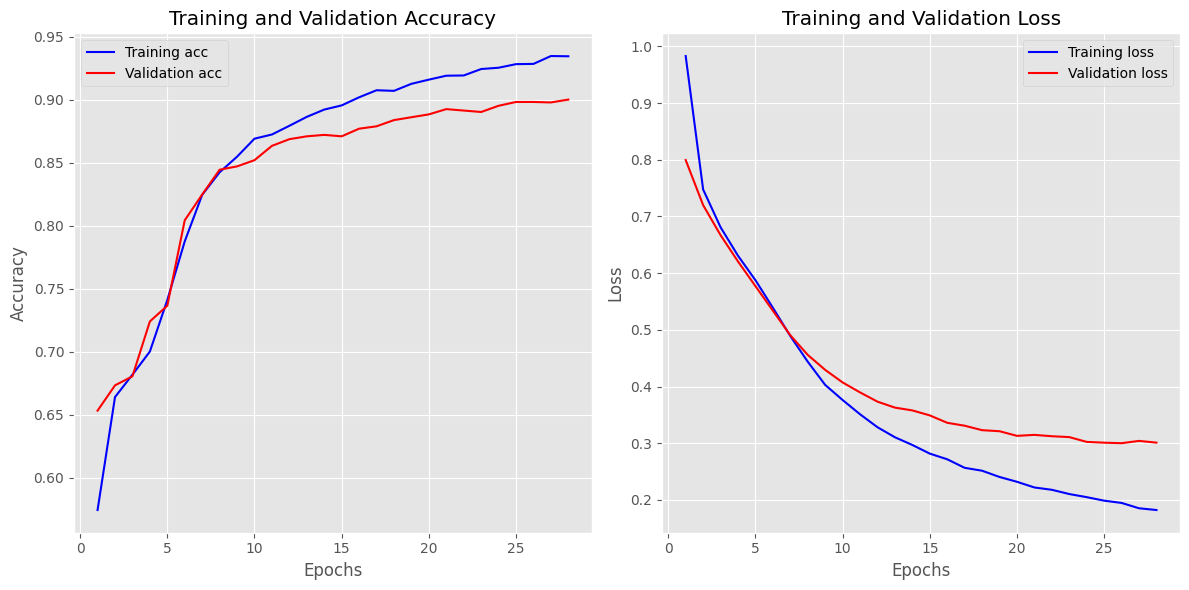

In [11]:
# Visualize it

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b-', label='Training acc')
    plt.plot(x, val_acc, 'r-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b-', label='Training loss')
    plt.plot(x, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

plot_history(history)
plt.show()


In [12]:
# Save the model

model.save('model.h5')
print("Model has created!")

Model has created!


In [13]:
input_text = """
MAKANNYA ENAK BANGET  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 342ms/step
Text:  makannya enak banget  
Sentiment: positive


In [14]:
input_text = """
Makanannya PAYAH  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 449ms/step
Text:  makanannya payah  
Sentiment: negative
